In [7]:
# Available regions: 'Hirakud', 'Basantpur', 'Ghatora', 'Kurubhata', 'Rajim', 'Simga', 'Sundargarh'
REGION = 'Kurubhata'

# Available percentage for training: 50, 80, 100
training_percentage = 50

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import array
import matplotlib.pyplot as plt
from pathlib import Path

# Set random seeds for reproducibility
seed = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Base paths
DATA_DIR = Path('Data')
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)

# Model and training parameters
N_STEPS_IN, N_STEPS_OUT = 30, 5 # Look back 30 days to predict next 5 days
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

In [25]:
# Available regions: 'Hirakud', 'Basantpur', 'Ghatora', 'Kurubhata', 'Rajim', 'Simga', 'Sundargarh'
# REGION = 'Kurubhata'

# Base configuration
BASE_FEATURES = {
    'Hirakud': {
        'features': ['Mean_areal_rainfall_upper', 'Inflow', 'Sundargarh', 'Kurubhata'],
        'target': 'Inflow'
    },
    'Basantpur': {
        'features': ['Mean_areal_rainfall_upper', 'Basantpur', 'Rajim', 'Simga', 'Ghatora'],
        'target': 'Basantpur'
    },
    'Ghatora': {
        'features': ['Mean_areal_rainfall_upper', 'Ghatora'],
        'target': 'Ghatora'
    },
    'Kurubhata': {
        'features': ['Mean_areal_rainfall_upper', 'Kurubhata'],
        'target': 'Kurubhata'
    },
    'Rajim': {
        'features': ['Mean_areal_rainfall_upper', 'Rajim'],
        'target': 'Rajim'
    },
    'Simga': {
        'features': ['Mean_areal_rainfall_upper', 'Simga'],
        'target': 'Simga'
    },
    'Sundargarh': {
        'features': ['Mean_areal_rainfall_upper', 'Sundargarh'],
        'target': 'Sundargarh'
    }
}

# Generate output columns dynamically
def get_output_columns(features, region):
    columns = {'Mean_areal_rainfall_upper': 'rainfall'}
    for feat in features:
        if feat != 'Mean_areal_rainfall_upper':
            columns[feat] = feat.lower() + ('_discharge' if feat != 'rainfall' else '')
    return columns

# Build final config
current_config = BASE_FEATURES.get(REGION)
if not current_config:
    raise ValueError(f"Configuration for region '{REGION}' not found.")

# Set global variables
FEATURES = current_config['features']
TARGET_FEATURE = current_config['target']
OUTPUT_COLUMNS = get_output_columns(FEATURES, REGION)
TARGET_FEATURE_NAME = OUTPUT_COLUMNS[TARGET_FEATURE]
FEATURES_TO_USE = list(OUTPUT_COLUMNS.values())
MODEL_SAVE_PATH = f"best_mlp_mann_model_{REGION}.pth"
RAW_TEST_FILE_PATH = f"Data/raw_test_y_{REGION.lower()}.csv"


# Load and prepare data
data = pd.read_excel('Data/new data.xlsx')
data = data[['Date'] + FEATURES].rename(columns=OUTPUT_COLUMNS)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').ffill().bfill()

/var/folders/_w/4xfs9wld05nfzlbq4p03y6z80000gn/T/ipykernel_6796/3753173883.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


In [10]:
data.head(5)

,rainfall,kurubhata_discharge
Date,,
2000-06-01,1.896728,0.000
2000-06-02,1.223008,0.000
2000-06-03,2.578513,0.000
2000-06-04,1.107180,2.854
2000-06-05,1.633354,3.271


In [ ]:
def get_train_test_split(data, training_percentage=100):
    # Define the split points based on percentage
    split_dates = {
        100: '2000-01-01',  # 100% of data -> 4017 days
        80: '2002-01-01',   # 80% of data -> 3286 days
        50: '2005-01-01',    # 50% of data -> 2190 days
        20: '2008-01-01'
    }
    
    if training_percentage not in split_dates:
        raise ValueError("training_percentage must be one of: 50, 80, or 100")      # Would like to change to a continous form
    
    # Split the data
    train_start = split_dates[training_percentage]
    data_train = data.loc[train_start:'2010-12-31'].copy()
    data_test = data.loc['2011-01-01':'2014-12-31'].copy()
    
    return data_train, data_test

# usage:
# training_percentage = 50
data_train, data_test = get_train_test_split(data, training_percentage)

# Keep raw test target before processing
raw_data_test_target = data_test[[TARGET_FEATURE_NAME]].copy()

# Smooth features
for col in FEATURES_TO_USE:
    window = np.blackman(20)
    data_train[col] = np.convolve(window/window.sum(), data_train[col].values, 'same')
    data_test[col] = np.convolve(window/window.sum(), data_test[col].values, 'same')

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_train)
train_scaled = scaler.transform(data_train)
test_scaled = scaler.transform(data_test)

In [14]:
# Get the index of the target column in the feature set
target_col_index = FEATURES_TO_USE.index(TARGET_FEATURE_NAME)

def create_sequences(data, n_steps_in, n_steps_out, target_idx):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i+n_steps_in])
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out, target_idx])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(train_scaled, N_STEPS_IN, N_STEPS_OUT, target_col_index)

# Split into train/validation
train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# Create DataLoaders
train_data = TensorDataset(
    torch.tensor(train_X, dtype=torch.float32),
    torch.tensor(train_y, dtype=torch.float32)
)
val_data = TensorDataset(
    torch.tensor(val_X, dtype=torch.float32),
    torch.tensor(val_y, dtype=torch.float32)
)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# --- 4. MODEL DEFINITION (MLP+MANN) ---
class MLP_MANN_Model(nn.Module):
    def __init__(self, input_dim, n_steps_in, n_steps_out, memory_size=128, memory_dim=64, hidden_dim=256):
        super(MLP_MANN_Model, self).__init__()
        flattened_input_dim = n_steps_in * input_dim
        self.memory = nn.Parameter(torch.randn(memory_size, memory_dim))
        nn.init.xavier_uniform_(self.memory)
        self.input_projection = nn.Linear(flattened_input_dim, memory_dim)
        self.dense1 = nn.Linear(flattened_input_dim + memory_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.output_layer = nn.Linear(hidden_dim // 2, n_steps_out)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        flat_x = x.view(x.size(0), -1)
        projected_input = self.input_projection(flat_x)
        attention_scores = torch.matmul(projected_input, self.memory.t())
        attention_weights = self.softmax(attention_scores)
        memory_output = torch.matmul(attention_weights, self.memory)
        augmented_input = torch.cat([flat_x, memory_output], dim=1)
        h1 = self.relu(self.dense1(augmented_input))
        h2 = self.relu(self.dense2(h1))
        output = self.output_layer(h2)
        return output

In [23]:
def train_step(model, batch_X, batch_y, criterion, optimizer, device):
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        total_loss += criterion(outputs, y_batch).item()
    return total_loss / len(data_loader)

def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device, model_path):
    model = model.to(device)
    best_val_loss = float('inf')
    history = {'train': [], 'val': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            train_loss += train_step(model, batch_X, batch_y, criterion, optimizer, device)
        
        # Validation phase
        val_loss = evaluate(model, val_loader, criterion, device)
        train_loss /= len(train_loader)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
        
        # Record history
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Training setup
input_dim = X.shape[-1]
model = MLP_MANN_Model(input_dim, N_STEPS_IN, N_STEPS_OUT)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Create model path with region name
model_path = MODEL_DIR / f"best_mlp_mann_model_{REGION}.pth"

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    model_path=str(model_path)  # Convert Path to string for PyTorch
)

Using device: cpu
Epoch   1/50 | Train Loss: 0.090559 | Val Loss: 0.071135
Epoch   2/50 | Train Loss: 0.067599 | Val Loss: 0.049523
Epoch   3/50 | Train Loss: 0.046386 | Val Loss: 0.033748
Epoch   4/50 | Train Loss: 0.033382 | Val Loss: 0.027350
Epoch   5/50 | Train Loss: 0.029685 | Val Loss: 0.025655
Epoch   6/50 | Train Loss: 0.027450 | Val Loss: 0.023824
Epoch   7/50 | Train Loss: 0.024222 | Val Loss: 0.021970
Epoch   8/50 | Train Loss: 0.022919 | Val Loss: 0.020277
Epoch   9/50 | Train Loss: 0.019831 | Val Loss: 0.018912
Epoch  10/50 | Train Loss: 0.017915 | Val Loss: 0.017387
Epoch  11/50 | Train Loss: 0.016603 | Val Loss: 0.016179
Epoch  12/50 | Train Loss: 0.014560 | Val Loss: 0.015148
Epoch  13/50 | Train Loss: 0.013650 | Val Loss: 0.014049
Epoch  14/50 | Train Loss: 0.012583 | Val Loss: 0.013563
Epoch  15/50 | Train Loss: 0.011724 | Val Loss: 0.012518
Epoch  16/50 | Train Loss: 0.011399 | Val Loss: 0.012592
Epoch  17/50 | Train Loss: 0.010600 | Val Loss: 0.011748
Epoch  18/50 


--- 6. Plotting Training and Validation Loss ---


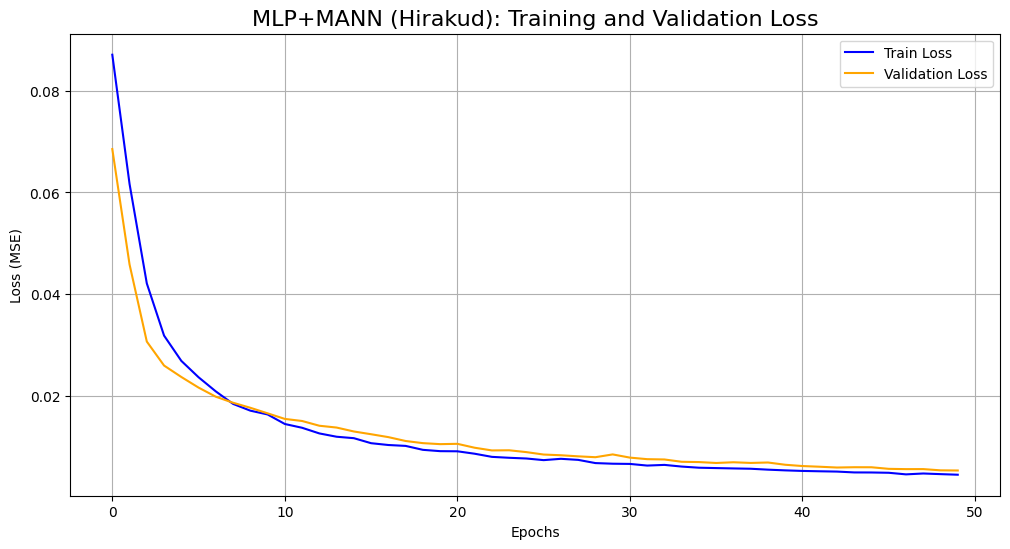

In [21]:
# --- 6. POST-TRAINING ANALYSIS ---
print("\n--- 6. Plotting Training and Validation Loss ---")
if history:  # Check if history exists
    plt.figure(figsize=(12, 6))
    plt.plot(history['train'], label='Train Loss', color='blue')
    plt.plot(history['val'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('MLP+MANN (Hirakud): Training and Validation Loss', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
# --- 7. FINAL EVALUATION ---
# Create test sequences
X_test, y_test_scaled = create_sequences(test_scaled, N_STEPS_IN, N_STEPS_OUT, target_col_index)
print(f"Testing on {X_test.shape[0]} samples")

# Load best model from the models directory
model_path = MODEL_DIR / f"best_mlp_mann_model_{REGION}.pth"
model.load_state_dict(torch.load(model_path))
model.to(device).eval()

# Get predictions
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    test_predictions_scaled = model(X_test_tensor).cpu().numpy()

# Inverse scaling function
def inverse_scale_data(scaled_data, original_scaler, n_features, target_idx):
    dummy = np.zeros((scaled_data.size, n_features))
    dummy[:, target_idx] = scaled_data.flatten()
    return original_scaler.inverse_transform(dummy)[:, target_idx].reshape(scaled_data.shape)

# Apply inverse scaling
n_features = train_scaled.shape[1]
y_test_inv = inverse_scale_data(y_test_scaled, scaler, n_features, target_col_index)
test_predictions_inv = inverse_scale_data(test_predictions_scaled, scaler, n_features, target_col_index)

# Load raw test data
raw_y_test = pd.read_csv(RAW_TEST_FILE_PATH, header=0, dtype=float).values
num_samples = raw_y_test.shape[0]
print(f"Loaded raw test data with {num_samples} samples")

# Align and calculate offset
y_test_raw = raw_y_test[:num_samples]
y_test_smoothed = y_test_inv[:num_samples]
y_predict_smoothed = test_predictions_inv[:num_samples]

# Apply offset
offset = y_test_raw - y_test_smoothed
y_predict_adjusted = y_predict_smoothed + offset
print("Offset calculation and adjustment complete")

Testing on 454 samples
Loaded raw test data with 454 samples
Offset calculation and adjustment complete


Test RMSE (Adjusted vs Raw): 76.0006

Metrics per prediction step (t+1 to t+5):
NSE:    ['0.9785', '0.9581', '0.9186', '0.8768', '0.8183']
RSR:    ['0.1466', '0.2048', '0.2854', '0.3510', '0.4262']
PBIAS:  ['-1.53%', '-1.68%', '-4.39%', '-5.72%', '-8.83%']
TPE:    ['13.31%', '18.63%', '25.18%', '30.44%', '36.53%']


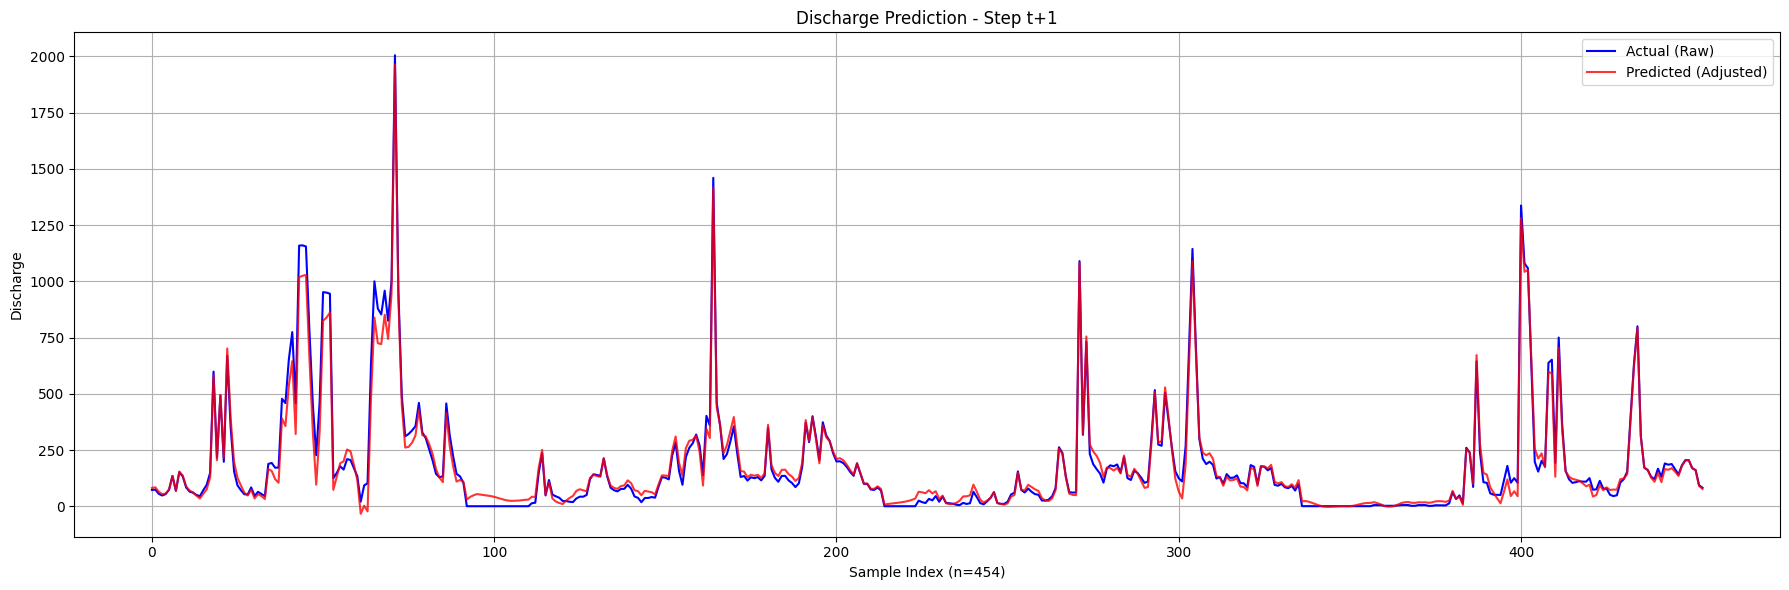

In [27]:
# --- 8. PERFORMANCE EVALUATION ---
def calculate_metrics(observed, predicted):
    """Calculate NSE, RSR, PBIAS, and TPE metrics."""
    if np.sum(observed) == 0 or np.sum((observed - np.mean(observed)) ** 2) == 0:
        return -np.inf, np.inf, np.inf, np.inf
    
    nse = 1 - (np.sum((observed - predicted) ** 2) / 
               np.sum((observed - np.mean(observed)) ** 2))
    rsr = np.sqrt(np.sum((observed - predicted) ** 2)) / \
          np.sqrt(np.sum((observed - np.mean(observed)) ** 2))
    pbias = (np.sum(predicted - observed) / np.sum(observed)) * 100
    tpe = (np.sum(np.abs(observed - predicted)) / np.sum(observed)) * 100
    
    return nse, rsr, pbias, tpe

# Calculate overall RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_predict_adjusted))
print(f"Test RMSE (Adjusted vs Raw): {test_rmse:.4f}")

# Calculate metrics for each prediction step
metrics = [calculate_metrics(y_test_raw[:, i], y_predict_adjusted[:, i]) 
           for i in range(N_STEPS_OUT)]
nse_values, rsr_values, pbias_values, tpe_values = zip(*metrics)

# Print metrics
print("\nMetrics per prediction step (t+1 to t+5):")
print(f"NSE:    {[f'{x:.4f}' for x in nse_values]}")
print(f"RSR:    {[f'{x:.4f}' for x in rsr_values]}")
print(f"PBIAS:  {[f'{x:.2f}%' for x in pbias_values]}")
print(f"TPE:    {[f'{x:.2f}%' for x in tpe_values]}")

# Plot results
plt.figure(figsize=(18, 6))
step_to_plot = 0  # Plotting first prediction step (t+1)
plt.plot(y_test_raw[:, step_to_plot], 'b-', label='Actual (Raw)')
plt.plot(y_predict_adjusted[:, step_to_plot], 'r-', 
         label='Predicted (Adjusted)', alpha=0.8)

plt.title(f'Discharge Prediction - Step t+{step_to_plot + 1}')
plt.xlabel(f'Sample Index (n={y_test_raw.shape[0]})')
plt.ylabel('Discharge')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()